# Part 4 - Fun With Convolutional Networks

In Parts 2 & 3 we applied a 3-layer perceptron (with 400, 150 hidden units) to the MNIST and Fashion-MNIST respectively. In terms of numbers of layers, this is probably the smallest network you could describe as 'deep learning' but as we've seen it does a decent job, giving a similar level of performance to state-of-the-art SVMs. 

Let's move on to a convolutional network. Given the significant increase in model complexity, we'd really hope to do a better job than the 3-layer perceptron and the SVM models. Quite often, you see Keras tutorials on this same dataset with very complex convolutional network (which Keras makes easy to do) but those models frequently don't actually get any better performance on the task than we've managed to do with the 3-layer perceptron, or could be done with other machine learning models, like an SVM (but with a massively increased training time).

Let's build a couple of convolutional models and see see how our performance compares to the previous model on both datasets.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from tensorflow.python.framework import ops
from preprocess_conv import random_mini_batches

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

mnist = tf.keras.datasets.mnist
fashion_mnist = tf.keras.datasets.fashion_mnist


/home/nickdbn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


As we did previously (parts 2 and 3), we're going to import the MNIST and the Fashion MNIST in parallel. To be clear - we're going to train separate models on each dataset, but here we're loading and processing the data all together.

In [2]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [3]:
(f_x_train, f_y_train_orig),(f_x_test, f_y_test_orig) = fashion_mnist.load_data()
(d_x_train, d_y_train_orig), (d_x_test, d_y_test_orig) = mnist.load_data()

f_x_train, f_x_test = f_x_train / 255.0, f_x_test / 255.0 # normalise
d_x_train, d_x_test = d_x_train / 255.0, d_x_test / 255.0 # normalise

# reshape y to arrays of shape (m,1)
#f_y_train, f_y_test = f_y_train.reshape(f_y_train.shape[0], 1), f_y_test.reshape(f_y_test.shape[0], 1)
#d_y_train, d_y_test = d_y_train.reshape(d_y_train.shape[0], 1), d_y_test.reshape(d_y_test.shape[0], 1)

f_x_train = f_x_train.reshape(f_x_train.shape[0], f_x_train.shape[1], f_x_train.shape[2], 1)
f_x_test = f_x_test.reshape(f_x_test.shape[0], f_x_test.shape[1], f_x_test.shape[2], 1)
d_x_train = d_x_train.reshape(d_x_train.shape[0], d_x_train.shape[1], d_x_train.shape[2], 1)
d_x_test = d_x_test.reshape(d_x_test.shape[0], d_x_test.shape[1], d_x_test.shape[2], 1)

f_y_train = convert_to_one_hot(f_y_train_orig, 10).T
f_y_test = convert_to_one_hot(f_y_test_orig, 10).T
d_y_train = convert_to_one_hot(d_y_train_orig, 10).T
d_y_test = convert_to_one_hot(d_y_test_orig, 10).T


print ("f_x_train shape:", f_x_train.shape)
print ("f_y_train shape:", f_y_train.shape)
print ("f_x_test shape:", f_x_test.shape)
print ("f_y_test shape:", f_y_test.shape)
print ("d_x_train shape:", d_x_train.shape)
print ("d_y_train shape:", d_y_train.shape)
print ("d_x_test shape:", d_x_test.shape)
print ("d_y_test shape:", d_y_test.shape)

f_x_train shape: (60000, 28, 28, 1)
f_y_train shape: (60000, 10)
f_x_test shape: (10000, 28, 28, 1)
f_y_test shape: (10000, 10)
d_x_train shape: (60000, 28, 28, 1)
d_y_train shape: (60000, 10)
d_x_test shape: (10000, 28, 28, 1)
d_y_test shape: (10000, 10)


In [4]:
# Temporary - code broken by changing dimensionalty of X data to [m, h, w, c] where c =1

#display_examples_n = 40
#rows = 6
#cols = 8
#fig, axarr = plt.subplots(rows, cols)
#
#for r in range (0, rows):
#    for c in range (0, cols):
#        axarr[r][c].title.set_text(str(f_y_train_orig[(r*cols)+c]))
#        axarr[r][c].imshow(f_x_train[(r*cols)+c])
        
#for r in range (3, rows):
#    for c in range (0, cols):
#        axarr[r][c].title.set_text(str(d_y_train_orig[(r*cols)+c]))
#        axarr[r][c].imshow(d_x_train[(r*cols)+c])

On this occasion, we're not going to bother carving the training set into a train/dev set. If we end up doing a lot of hyperparameter tuning we'll come back and do it. 

# The Model

In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(dtype=tf.float32, shape=[None, n_H0, n_W0, n_C0], name="X")
    Y = tf.placeholder(dtype=tf.float32, shape=[None, n_y], name="Y")
    
    return X, Y

In [6]:
X, Y = create_placeholders(28, 28, 1, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 28, 28, 1), dtype=float32)
Y = Tensor("Y:0", shape=(?, 10), dtype=float32)


The two convolutional layers we'll use are 4x4x1x8 (4x4x1 filter with 8 channels) and 2x2x8x16 (2x2x8 filter with 16 channels)

In [28]:
def initialize_parameters_simple():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
        
    W1 = tf.get_variable("W1", [4, 4, 1, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [29]:
def forward_propagation_simple(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')

    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    P2 = tf.contrib.layers.flatten(P2) 
    
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=10, activation_fn=None)

    return Z3

# Running the model
Once again, we're using a three-layer model (i.e. a multi-layer perceptron), with layers l1 = 400, l2 = 150, l3 = 10, with l1 through l3 using relu units, and l4 a softmax layer. The parameters are trained via backprop optimising to softmax cross-entropy loss. 

L2 regularization didn't seem to help much on the digits dataset but who knows, let's leave it in here. The default setting of beta is zero.

In [9]:
def plot_training_by_epoch (costs, train_accuracy, test_accuracy, learning_rate):
    
    fig, ax1 = plt.subplots() 
    
    # plot cost on primary y axis 
    cost = ax1.plot(np.squeeze(costs), label="cost", color='b')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('cost', color='b')
    ax1.tick_params('y', colors='b')
    
    # plot accuracy on secondary y axis
    ax2 = ax1.twinx()
    train_accuracy = ax2.plot(np.squeeze(train_accuracy), 
                              label="train accuracy", color='r', linestyle='-.')
    test_accuracy = ax2.plot(np.squeeze(test_accuracy), 
                             label="test accuracy", color='r', linestyle=':')
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.legend(bbox_to_anchor=(1, 1))
    
    plt.title("Learning rate =" + str(learning_rate))
    fig.tight_layout()
    plt.show()

In [10]:
def compute_cost(ZL, Y):
    """
    Computes the cost
    
    Arguments:
    ZL -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as ZL
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=ZL, labels=Y))
    
    return cost

In [35]:
def model(X_train, Y_train, X_test, Y_test, network = 'simple', learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                               # To keep track of the cost
    train_accuracy = []                      # for plotting per epoch
    test_accuracy = []                       # for plotting per epoch

    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    if network == 'lenet5':
        parameters = initialize_parameters_lenet()
        ZL = forward_propagation_lenet(X, parameters)
        cost = compute_cost(ZL, Y)
    else:
        parameters = initialize_parameters_simple()
        ZL = forward_propagation_simple(X, parameters)
        cost = compute_cost(ZL, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer (learning_rate = learning_rate).minimize(cost)
        
    # Graph for calculating the correct prediction
    predict_op = tf.argmax(ZL, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
    # Graph for calculating accuracy on the test set (so we can plot it on the fly)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    tic = time.time()
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})                
                minibatch_cost += temp_cost / num_minibatches
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                timer = time.time() - tic
                print ("Cost after epoch %i: %f, running for %f seconds" % (epoch, 
                                                                            epoch_cost, timer))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                # evaluate accuracy
                train_accuracy.append (accuracy.eval({X: X_train, Y: Y_train}))
                test_accuracy.append (accuracy.eval({X: X_test, Y: Y_test}))

        
        # plot the cost
        plot_training_by_epoch (costs, train_accuracy, test_accuracy, learning_rate)
        


        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return parameters, costs, train_accuracy, test_accuracy

## Default model run

Cost after epoch 0: 1.155331, running for 11.253465 seconds
Cost after epoch 5: 0.331001, running for 74.497088 seconds


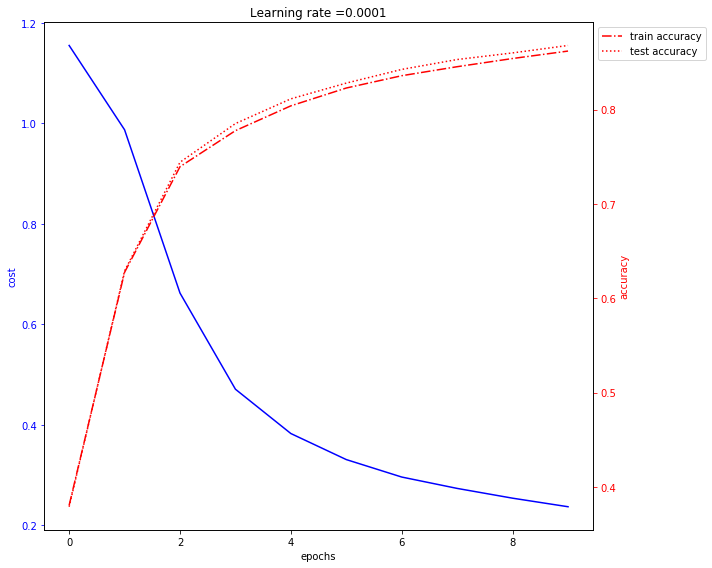

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.86216664
Test Accuracy: 0.8681


In [31]:
parameters, costs, train_accuracy, test_accuracy = model(d_x_train, d_y_train, 
                                                         d_x_test, d_y_test, 
                                                         network='simple',
                                                         learning_rate = 0.0001, 
                                                         num_epochs = 10)

In [ ]:
                # just a reminder that we can now plot outside the model training function
# plot_training_by_epoch (costs, train_accuracy, test_accuracy, learning_rate = 0.0001)

Training for 20 epochs (about 4 minutes on my CPU only), the model achieves ##accuracy. In comparison, in part 2 after 20 epochs we achieved 97.4% accuracy, after slightly more training time. 

Really interestingly, the train and test accuracy are basically interchangeable for the entire training set - i.e. a variance of near-zero. This is unexpected - could it be due to the simplicity of the conv net? (i.e., only convolutional and pooling layers with only a single fully connected layer?

Now let's try the model on the Fashion-MNIST

Cost after epoch 0: 1.116347, running for 11.277927 seconds
Cost after epoch 5: 0.415109, running for 76.503365 seconds
Cost after epoch 10: 0.352841, running for 153.524980 seconds
Cost after epoch 15: 0.327475, running for 228.881660 seconds
Cost after epoch 20: 0.309862, running for 314.575245 seconds
Cost after epoch 25: 0.302125, running for 399.695093 seconds
Cost after epoch 30: 0.292205, running for 477.962178 seconds
Cost after epoch 35: 0.287303, running for 538.024477 seconds


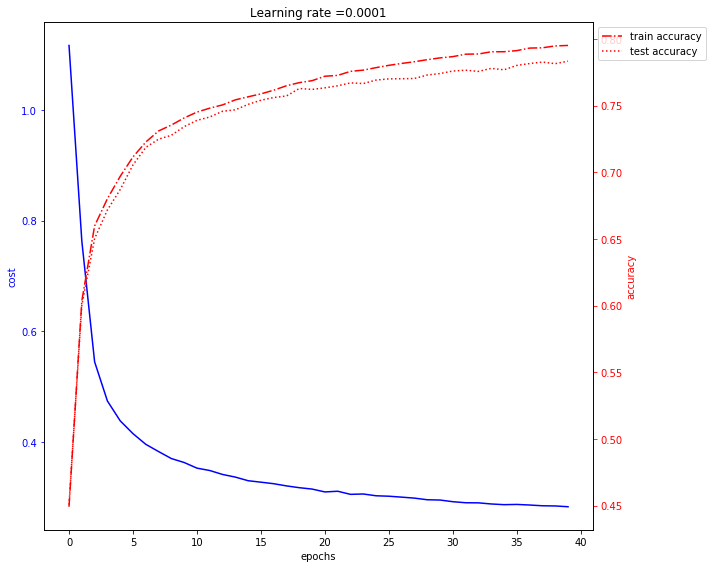

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.7951667
Test Accuracy: 0.7834


In [26]:
parameters, costs, train_accuracy, test_accuracy = model(f_x_train, f_y_train, 
                                                         f_x_test, f_y_test, 
                                                         learning_rate = 0.0001, 
                                                         num_epochs = 40)

# LeNet-5

Let's implement a slightly more complicated version of the previous conv net, with slightly bigger convolutional/pooling layers and a few more fully connected layers before the softmax. This is similar (but not the same!!) to LeNet-5 

In [64]:
def calc_conv_output_size (n_H_prev, n_W_prev, f, pad, stride):    
    n_H = int (((n_H_prev - f + (2 * pad))/stride) + 1)
    n_W = int (((n_W_prev - f + (2 * pad))/stride) + 1)
    return (n_H, n_W)

In [73]:
print ("conv1 dimensions: ", calc_conv_output_size (28, 28, f=5, pad=2, stride=1))
print ("pool1 dimensions: ", calc_conv_output_size (28, 28, f=2, pad=0, stride=2))
print ("conv2 dimensions: ", calc_conv_output_size (14, 14, f=5, pad=0, stride=1))
print ("pool2 dimensions: ", calc_conv_output_size (10, 10, f=2, pad=0, stride=2))

conv1 dimensions:  (28, 28)
pool1 dimensions:  (14, 14)
conv2 dimensions:  (10, 10)
pool2 dimensions:  (5, 5)


In [80]:
def initialize_parameters_lenet():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
        
    W1 = tf.get_variable("W1", [5, 5, 1, 6], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5, 5, 6, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    # flatten layer *should* contain 400 units
    W3 = tf.get_variable ("W3", [120,400], 
                          initializer = tf.contrib.layers.xavier_initializer(seed=1))
    W4 = tf.get_variable ("W4", [84,120], 
                          initializer = tf.contrib.layers.xavier_initializer(seed=1))
    W5 = tf.get_variable ("W5", [10,84], 
                          initializer = tf.contrib.layers.xavier_initializer(seed=1))
    
    b3 = tf.get_variable ("b3", [120,1], 
                          initializer = tf.zeros_initializer())
    b4 = tf.get_variable ("b4", [84,1], 
                          initializer = tf.zeros_initializer())
    b5 = tf.get_variable ("b5", [10,1], 
                          initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3,
                  "W4": W4,
                  "W5": W5,
                  "b3": b3,
                  "b4": b4,
                  "b5": b5}
    
    return parameters

In [85]:
def forward_propagation_lenet(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    #W3 = parameters['W3']
    #W4 = parameters['W4']
    #W5 = parameters['W5']
    #b3 = parameters['b3']
    #b4 = parameters['b4']
    #b5 = parameters['b5']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME', name='conv1') # output 28x28x6
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', name='pool1')

    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='VALID', name='conv2')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', name='pool2')
    F2 = tf.contrib.layers.flatten(P2) 
    
    FC3 = tf.contrib.layers.fully_connected(F2, num_outputs=120, 
                                             activation_fn=tf.nn.relu)
    FC4 = tf.contrib.layers.fully_connected(FC3, num_outputs=84, 
                                             activation_fn=tf.nn.relu)
    ZL = tf.contrib.layers.fully_connected(FC3, num_outputs=10, 
                                             activation_fn=None)
    
    #ZFC3 = tf.add(tf.matmul(W3, F2), b3) 
    #AFC3 = tf.nn.relu(ZFC3)
    
    #ZFC4 = tf.add(tf.matmul(W4, AFC3), b4)
    #AFC4 = tf.nn.relu(ZFC4)
    
    
    #ZL = tf.add(tf.matmul(W5, AFC4), b5)

    return ZL

In [ ]:
parameters, costs, train_accuracy, test_accuracy = model(f_x_train, f_y_train, 
                                                         f_x_test, f_y_test, 
                                                         network='lenet5',
                                                         learning_rate = 0.0001, 
                                                         num_epochs = 10)

Cost after epoch 0: 0.490584, running for 18.716098 seconds
